In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


from keras_visualizer import visualizer
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential, load_model
from keras.layers import LSTM, Dense, Dropout
from keras.utils.vis_utils import plot_model


In [24]:
# importing uber stock price data
df = pd.read_csv('amazon.csv')
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,01-05-2001,15.900000,17.000000,15.80,16.889999,16.889999,5107900
1,02-05-2001,17.139999,17.430000,16.84,17.110001,17.110001,7497200
2,03-05-2001,16.830000,17.000000,16.25,16.750000,16.750000,5010000
3,04-05-2001,16.350000,17.600000,15.93,17.559999,17.559999,6584500
4,07-05-2001,17.360001,17.530001,16.51,16.920000,16.920000,5083700


In [25]:
#Get the dimensions of the data
rows = df.shape[0]
columns = df.shape[1]
df.shape

(701, 7)

In [26]:
df.describe()

,Open,High,Low,Close,Adj Close,Volume
count,701.000000,701.000000,701.000000,701.000000,701.000000,7.010000e+02
mean,24.395235,24.958245,23.881398,24.452311,24.452311,8.707072e+06
std,14.747168,14.913531,14.589204,14.777773,14.777773,5.454427e+06
min,5.910000,6.100000,5.510000,5.970000,5.970000,2.348600e+06
25%,14.070000,14.460000,13.520000,14.060000,14.060000,5.731700e+06
50%,18.309999,18.920000,18.090000,18.570000,18.570000,7.432100e+06
75%,34.889999,35.730000,34.540001,34.980000,34.980000,9.831800e+06
max,60.389999,61.150002,59.009998,59.910000,59.910000,5.664590e+07


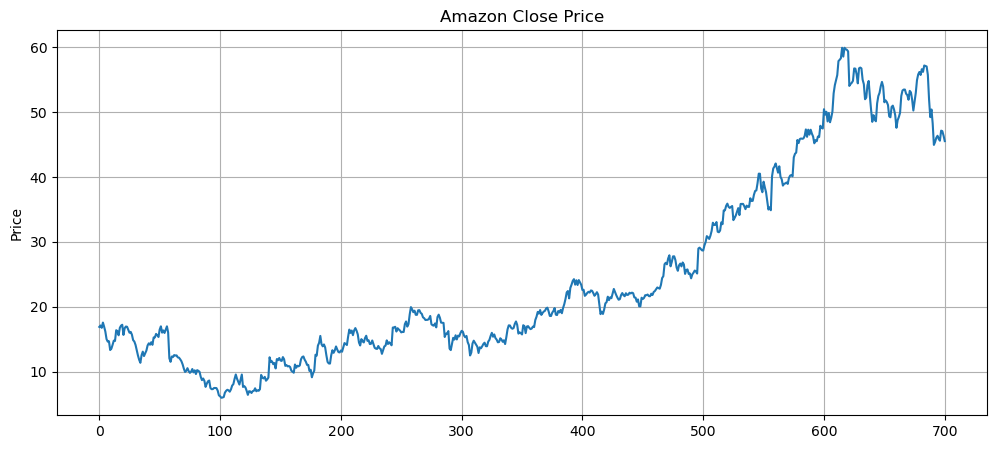

In [27]:
#Exploratory data analysis
plt.figure(figsize=(12,5))
plt.plot(df['Close'])
plt.title('Amazon Close Price')
plt.ylabel('Price')
plt.grid('on')
plt.show()

In [28]:
# Check for nulls
df.isnull().sum()

Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

In [29]:
attributes = ['Open', 'High', 'Low', 'Close', 'Volume']

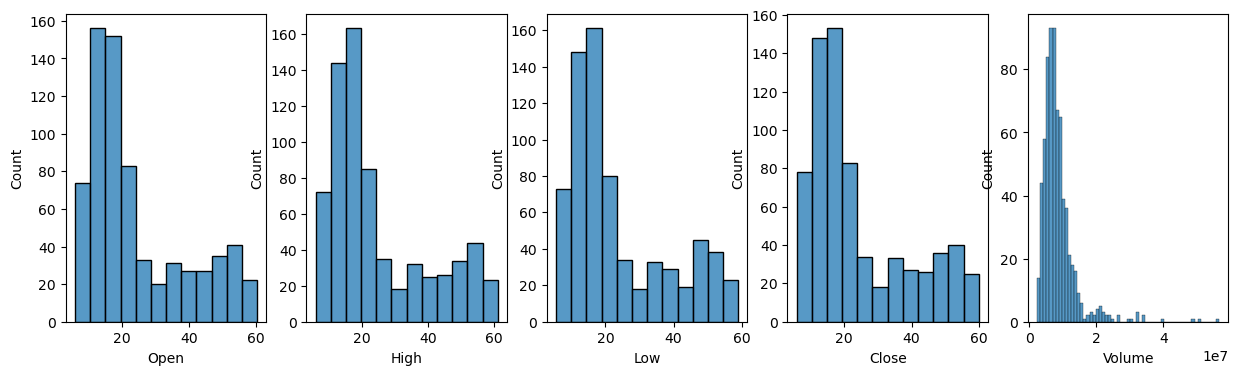

In [30]:
plt.figure(figsize=(15,4))
for i, attribute in enumerate(attributes):
    plt.subplot(1,5,i+1)
    sns.histplot(x=df[attribute])
plt.show()

# You notice one main peak around $30 which shows the price region where the price has varied the most
# Volume data is skewed left

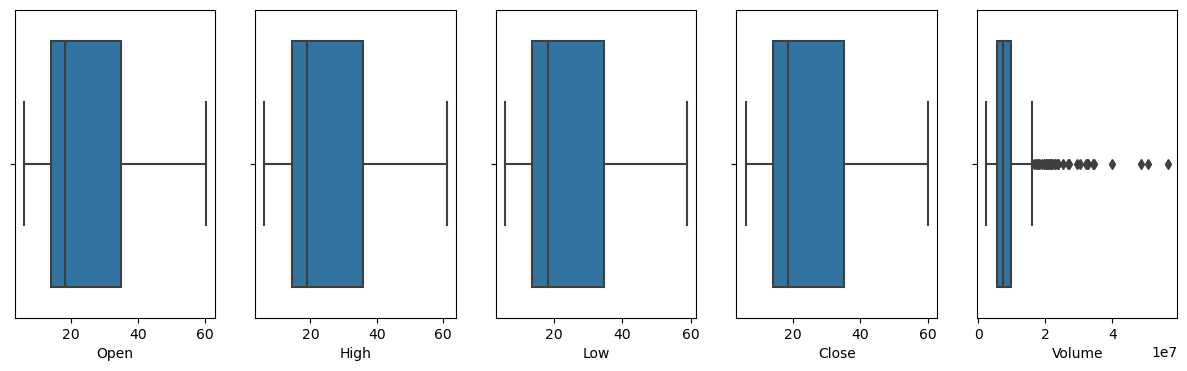

In [31]:
plt.figure(figsize=(15,4))
for i, attribute in enumerate(attributes):
    plt.subplot(1,5,i+1)
    sns.boxplot(x=df[attribute])
plt.show()

In [32]:

splitted = df['Date'].str.split('-', expand=True)
 
df['day'] = splitted[2].astype('int')
df['month'] = splitted[1].astype('int')
df['year'] = splitted[0].astype('int')
 
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume,day,month,year
0,01-05-2001,15.900000,17.000000,15.80,16.889999,16.889999,5107900,2001,5,1
1,02-05-2001,17.139999,17.430000,16.84,17.110001,17.110001,7497200,2001,5,2
2,03-05-2001,16.830000,17.000000,16.25,16.750000,16.750000,5010000,2001,5,3
3,04-05-2001,16.350000,17.600000,15.93,17.559999,17.559999,6584500,2001,5,4
4,07-05-2001,17.360001,17.530001,16.51,16.920000,16.920000,5083700,2001,5,7


<Figure size 2500x1000 with 0 Axes>

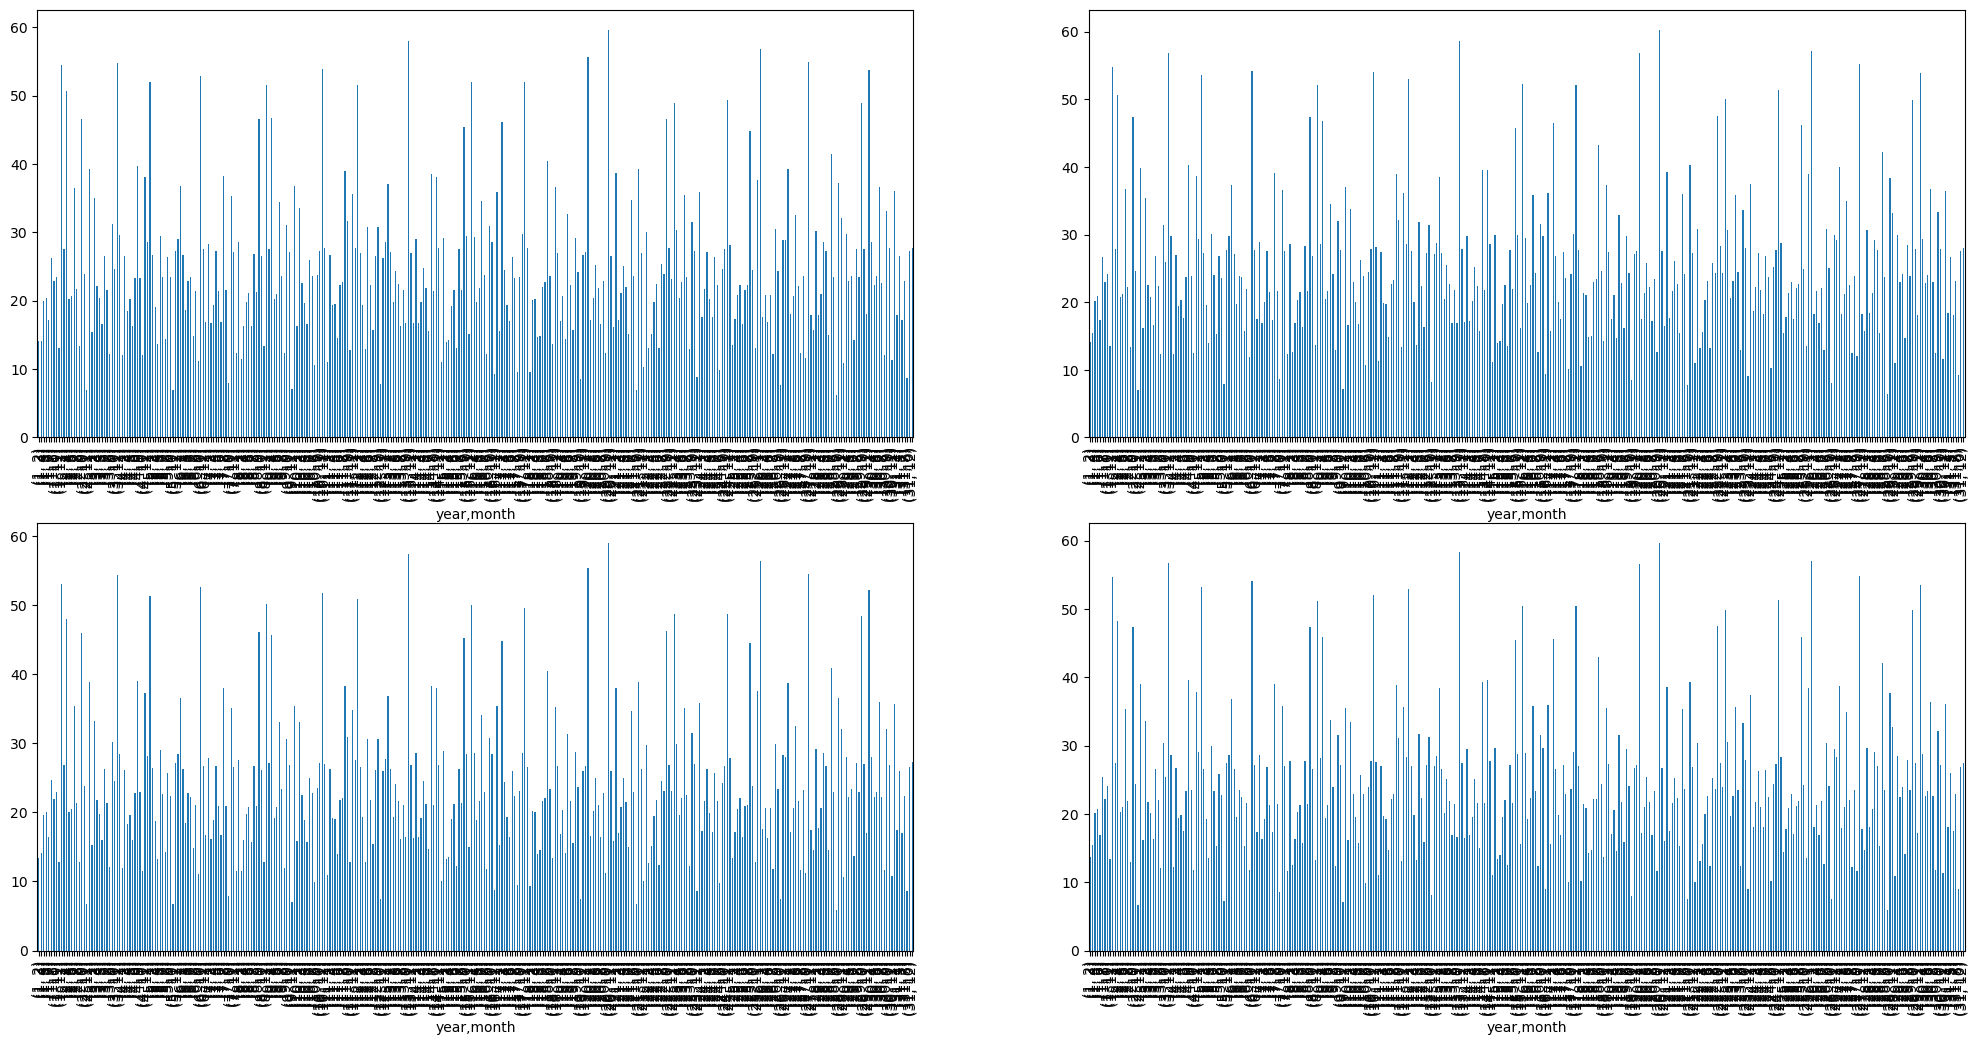

In [33]:
# average price each month of each year
plt.figure(figsize=(25,10))
data_grouped = df.groupby(['year', 'month']).mean()
fig, ax = plt.subplots(figsize=(20,10))
fig.tight_layout()
 
for i, col in enumerate(['Open', 'High', 'Low', 'Close']):
    plt.subplot(2,2,i+1)
    data_grouped[col].plot.bar()
   
plt.show()

In [34]:
# Calculating SMA
def get_sma(prices, rate):
    return prices.rolling(rate).mean()
    
closing_prices = df['Close']

sma = get_sma(closing_prices, 20) # 20 day SMA

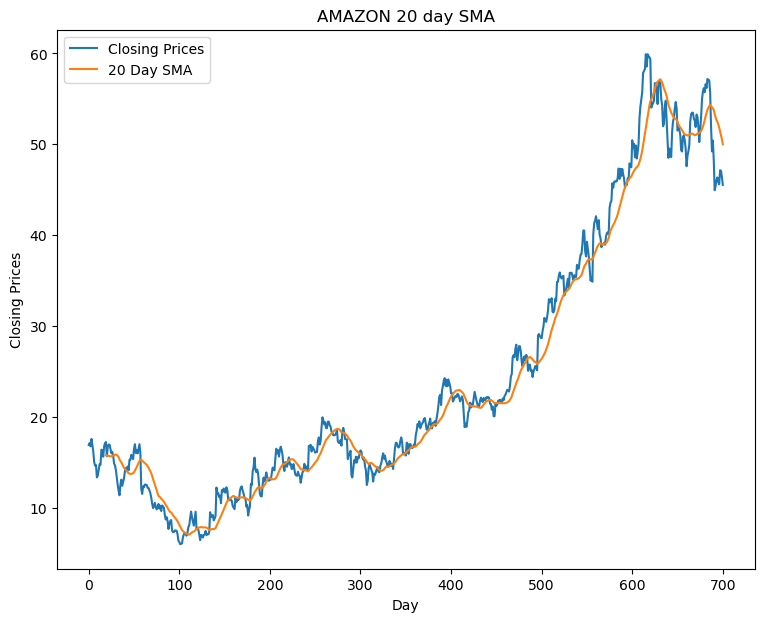

In [35]:
plt.figure(figsize=(9,7))
plt.title('AMAZON 20 day SMA')
plt.xlabel('Day')
plt.ylabel('Closing Prices')
plt.plot(closing_prices, label='Closing Prices')
plt.plot(sma, label='20 Day SMA')
plt.legend()
plt.show()

In [36]:
def get_bollinger_bands(prices, rate=20):
    sma = get_sma(prices, rate)
    std = prices.rolling(rate).std()
    bollinger_up = sma + std * 2
    bollinger_down = sma - std * 2
    return bollinger_up, bollinger_down

bollinger_up, bollinger_down = get_bollinger_bands(closing_prices)

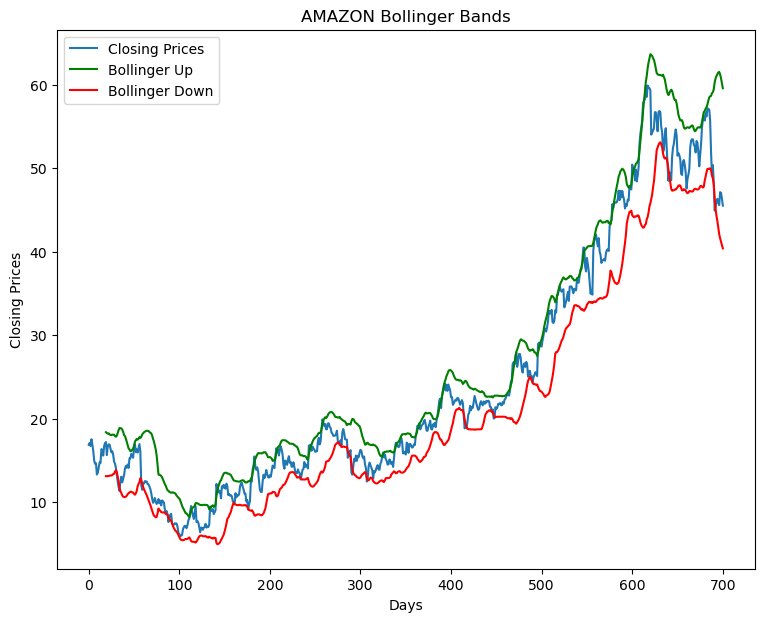

In [37]:
plt.figure(figsize=(9,7))
plt.title('AMAZON Bollinger Bands')
plt.xlabel('Days')
plt.ylabel('Closing Prices')
plt.plot(closing_prices, label='Closing Prices')
plt.plot(bollinger_up, label='Bollinger Up', c='g')
plt.plot(bollinger_down, label='Bollinger Down', c='r')
plt.legend()
plt.show()

In [38]:
def signal(sma, up, down):
    if sma > up:
        return 'buy'
    elif sma < down:
        return 'sell'
    else:
        return 'hold'
    
sma_list = sma.tolist()
up_list = bollinger_up.tolist()
down_list = bollinger_down.tolist()

signals = []

for i in range(len(sma_list)):
    signals.append(signal(sma[i], up_list[i], down_list[i]))

number_buys = signals.count('buy')
number_sells = signals.count('sell')
print(number_buys, number_sells)

#There were no days where the SMA crossed a bollinger band

0 0


In [39]:
# Setting up data to train Neural Network with
df_close = df['Close'].values
df_close = df_close.reshape(-1,1)
num_values = df_close.shape[0]

training_data = np.array(df_close[:int(df_close.shape[0]*0.8)])
testing_data = np.array(df_close[int(df.shape[0]*0.8):])

data_scaler = MinMaxScaler(feature_range=(0,1))
trainer = data_scaler.fit_transform(training_data)
tester = data_scaler.fit_transform(testing_data)

# Function for creating our training and testing data set
# Puts the last 50 prices in X and the next price in Y
def generate_data(df):
    x = []
    y = []
    for i in range(50, df.shape[0]):
        x.append(df[i-50:i, 0])
        y.append(df[i, 0])
    x = np.array(x)
    y = np.array(y)
    return x,y

# Creating the training and testing data
x_train, y_train = generate_data(trainer)
x_test, y_test = generate_data(tester)

# Building recurrent neural network: 
model = Sequential()
model.add(LSTM(units=96, return_sequences=True, input_shape=(x_train.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(units=96, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=96, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=96))
model.add(Dropout(0.2))
model.add(Dense(units=1))


# Reshaping x data so it can be used by a neural net
x_train = np.reshape(x_train,(x_train.shape[0], x_train.shape[1], 1))
x_test = np.reshape(x_test,(x_test.shape[0], x_test.shape[1], 1))

# Compile mile using MSE because problem is regression 
model.compile(loss='mean_squared_error', optimizer='adam', metrics=['accuracy'])

# Fitting the model to our data
model.fit(x_train, y_train, epochs=100, batch_size=32, verbose=0)

3/3 [==============================] - 0s 29ms/step


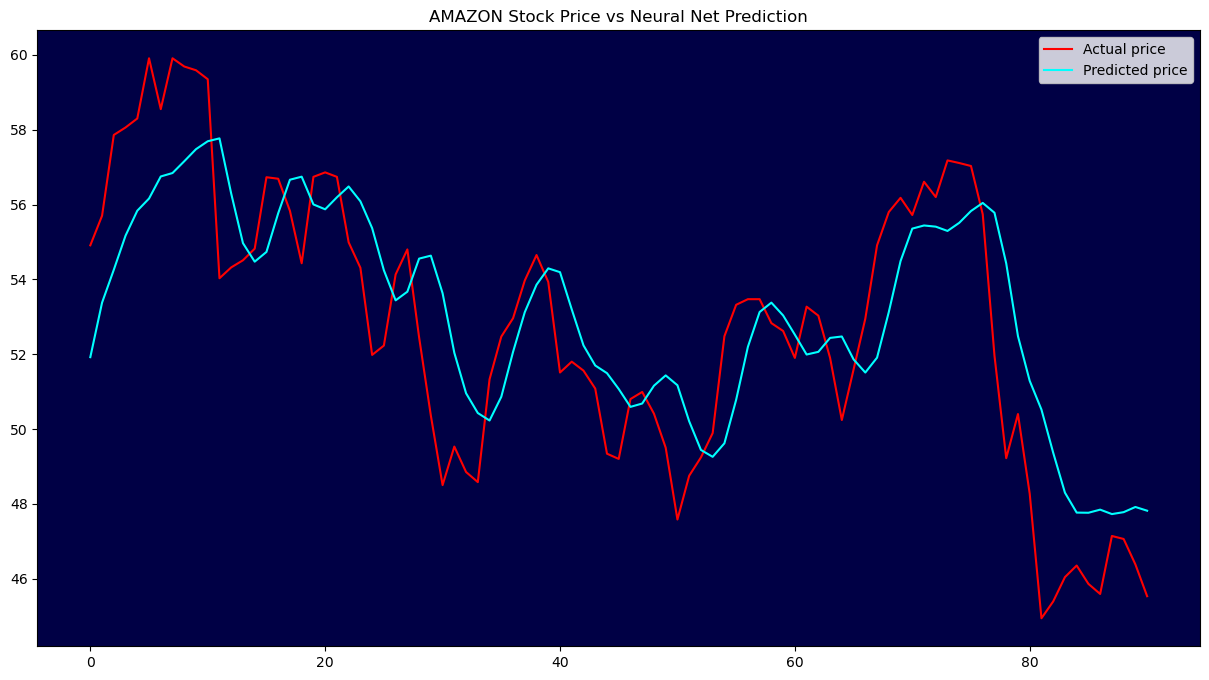

In [43]:
predict = model.predict(x_test)
# Scaling data back to original representation (dollars)
predict = data_scaler.inverse_transform(predict)
y_test_scaled = data_scaler.inverse_transform(y_test.reshape(-1,1))

# Plotting model results alongside actual price data
fig, ax = plt.subplots(figsize=(15,8))
ax.set_facecolor('#000045')
ax.plot(y_test_scaled, color='red', label='Actual price')
ax.plot(predict, color='cyan', label='Predicted price')
plt.title('AMAZON Stock Price vs Neural Net Prediction')
plt.legend()

In [41]:
from sklearn.metrics import mean_squared_error
from math import sqrt

In [42]:
rmse = sqrt(mean_squared_error(y_test_scaled,predict))
print(f"Root mean squared error (RMSE) : {rmse:.2f}")

Root mean squared error (RMSE) : 2.16
